# Finding "Matches" between the Top 2021 NCAA Basketball and NBA Players

# Introduction
For this project, we want to determine which basketball athletes in the NCAA that will perform well in the NBA, based on their statistics at the college level. We will do this by looking through the top 2021 NCAA players and try to see where they fall when compared to current and former NBA players college statistics, by determining a "match" - someone who performed simililarly in the NCAA. This might shine light on certain "sleeper" athlethes that recruiters might be ignoring or might determine if some athletes are overrated. 


# Setup and loading the data

To do process and analyze our data, we'll be importing all the neccessary data science libraries like pandas, matplot, and numpy, along with sklearn to help create models based on our data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from bs4 import BeautifulSoup
import requests

We will also be using the NBA comparsions players dataset retrieved from here, which itself has scraped the data from `basketball-reference.com` to get data on NBA/NCAA basketball players and has stored the data into the players.csv file. This data set is rich in entries, holding over 4000 players allowing us to get a good amount of data to play with.



In [2]:
nba_data = pd.read_csv("players.csv")
nba_data = nba_data.drop(columns=nba_data.columns[0]) # drop index

# drop urls, we aren't going to be needing them for our analysis
nba_data = nba_data.drop('url', axis=1)
nba_data

,active_from,active_to,birth_date,college,height,name,position,weight,NBA__3ptapg,NBA__3ptpct,...,NCAA__3ptpg,NCAA_efgpct,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
0,1991,1995,"June 24, 1968",Duke University,6-10,Alaa Abdelnaby,F-C,240.0,0.0,0.000,...,0.0,NaN,5.6,0.599,3.3,0.728,2.5,1.8,134.0,8.5
1,1969,1978,"April 7, 1946",Iowa State University,6-9,Zaid Abdul-Aziz,C-F,235.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1970,1989,"April 16, 1947","University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,225.0,0.0,0.056,...,NaN,NaN,16.8,0.639,10.7,0.628,7.9,5.0,88.0,26.4
3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,162.0,2.3,0.354,...,2.7,NaN,21.9,0.474,10.4,0.863,6.4,5.5,64.0,29.0
4,1998,2003,"November 3, 1974","University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,223.0,0.3,0.237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,2018,2018,"January 4, 1997",NaN,6-11,Ante Zizic,F-C,250.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4572,1983,1983,"December 20, 1953",Kent State University,7-1,Jim Zoet,C,240.0,0.0,NaN,...,NaN,NaN,2.9,0.476,1.4,0.429,1.0,0.4,63.0,3.2
4573,1971,1971,"June 7, 1948",Duquesne University,6-1,Bill Zopf,G,170.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4574,2017,2018,"March 18, 1997",NaN,7-1,Ivica Zubac,C,265.0,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will also scrape `sports-reference.com` to get the top 200 players in the NCAA that played in 2021 and try to gauge how well each of them will fit with NBA players.

I wrote `get_top_college_data` which would store the each of the top players in a dataframe. We will however be using preloading this into `top_2021_college_players.csv` file so that we don't have to rerun this script since it takes awhile.

In [3]:
def get_top_college_data ():
    base_url = 'https://www.sports-reference.com'
    player_url = []
    set_urls = set()
    with open("collegedata.html") as fp: # pre-saved html file as this was dynamically loaded on the sports-reference website
        soup = BeautifulSoup(fp, 'html.parser')
        for elmnt in soup.find_all('td', {'class': 'who'}) :
            child = elmnt.find("a" , recursive=False)
            url = base_url + child['href']
            if url not in set_urls:
                set_urls.add(url)
                player_url.append(url)
    
    frames = []
    for url in player_url :
        web = requests.get(url)
        soup = BeautifulSoup(web.content, 'html.parser')
        player_info  = soup.find(id='meta')
        name = player_info.find('h1', {'itemprop' : 'name'}).find('span').getText()
        weight = player_info.find('span', {'itemprop' : 'weight'}).getText()
        height = player_info.find('span', {'itemprop' : 'height'}).getText()

        tables = pd.read_html(url)
        college_stats = tables[0].iloc[-1].copy()
        college_stats['name'], college_stats['weight'], college_stats['height'] = name, weight, height
        frames.append(college_stats)
    return pd.DataFrame(frames)


In [4]:
# top_college_data = get_top_college_data()
# top_college_data.to_csv('top_2021_college_players.csv', encoding='utf-8')


In [5]:
top_college_players = pd.read_csv("top_2021_college_players.csv")
top_college_players = top_college_players.drop(columns=top_college_players.columns[0]) # drop index
top_college_players = top_college_players.reindex(columns=['name','School','height','weight','G','GS','MP','FG','FGA','FG%','2P','2PA','2P%','3P','3PA','3P%','FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS','SOS'])
top_college_players

,name,School,height,weight,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,SOS
0,Luka Garza,Iowa,6-11,265lb,127.0,118.0,27.1,6.9,12.6,0.546,...,2.7,4.6,7.3,1.2,0.5,1.2,1.4,2.4,18.2,9.50
1,Max Abmas,Oral Roberts,6-1,165lb,59.0,59.0,33.1,6.5,14.5,0.448,...,0.4,2.3,2.7,2.6,1.2,0.2,1.6,1.9,19.3,-0.81
2,Cameron Thomas,LSU,6-4,210lb,29.0,29.0,34.0,7.0,17.2,0.406,...,0.6,2.8,3.4,1.4,0.9,0.2,1.7,1.4,23.0,9.14
3,Drew Timme,Gonzaga,6-10,235lb,65.0,36.0,24.3,5.6,8.8,0.641,...,2.1,4.0,6.2,1.8,0.6,0.8,1.5,2.6,14.3,4.52
4,Corey Kispert,Gonzaga,6-7,220lb,137.0,108.0,27.4,4.1,8.4,0.483,...,1.0,3.1,4.0,1.4,0.7,0.4,1.0,1.6,11.6,4.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,CJ Fredrick,Iowa,6-3,195lb,52.0,52.0,26.6,3.1,6.4,0.479,...,0.4,1.1,1.5,2.3,0.5,0.2,0.8,1.3,8.8,10.53
204,Carl Pierre,UMass,6-4,190lb,111.0,100.0,32.0,4.1,10.4,0.399,...,0.5,2.2,2.7,1.4,0.6,0.1,0.9,2.0,12.2,1.44
205,Michael Ertel,Alabama-Birmingham,6-2,190lb,29.0,25.0,28.7,5.0,12.3,0.406,...,0.5,2.1,2.6,1.3,0.9,0.1,0.9,1.3,13.2,NaN
206,Noah Frederking,Evansville,6-4,210lb,121.0,59.0,24.2,2.3,5.8,0.393,...,0.4,1.6,2.0,0.8,0.4,0.1,0.8,1.0,6.7,0.52


## Cleaning Data
Currently we are storing height and weight as non-numeric values, so we should convert both to integers. We will store height in inches and weight in lbs

In [6]:
for i, row in top_college_players.iterrows():
    height, weight = row['height'], row['weight']
    ft, inches = [int(i) for i in height.split('-')]
    w = weight.strip('lb')
    top_college_players.at[i, 'height'] = ft * 12 + inches
    top_college_players.at[i, 'weight'] = float(w)
top_college_players


,name,School,height,weight,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,SOS
0,Luka Garza,Iowa,83,265,127.0,118.0,27.1,6.9,12.6,0.546,...,2.7,4.6,7.3,1.2,0.5,1.2,1.4,2.4,18.2,9.50
1,Max Abmas,Oral Roberts,73,165,59.0,59.0,33.1,6.5,14.5,0.448,...,0.4,2.3,2.7,2.6,1.2,0.2,1.6,1.9,19.3,-0.81
2,Cameron Thomas,LSU,76,210,29.0,29.0,34.0,7.0,17.2,0.406,...,0.6,2.8,3.4,1.4,0.9,0.2,1.7,1.4,23.0,9.14
3,Drew Timme,Gonzaga,82,235,65.0,36.0,24.3,5.6,8.8,0.641,...,2.1,4.0,6.2,1.8,0.6,0.8,1.5,2.6,14.3,4.52
4,Corey Kispert,Gonzaga,79,220,137.0,108.0,27.4,4.1,8.4,0.483,...,1.0,3.1,4.0,1.4,0.7,0.4,1.0,1.6,11.6,4.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,CJ Fredrick,Iowa,75,195,52.0,52.0,26.6,3.1,6.4,0.479,...,0.4,1.1,1.5,2.3,0.5,0.2,0.8,1.3,8.8,10.53
204,Carl Pierre,UMass,76,190,111.0,100.0,32.0,4.1,10.4,0.399,...,0.5,2.2,2.7,1.4,0.6,0.1,0.9,2.0,12.2,1.44
205,Michael Ertel,Alabama-Birmingham,74,190,29.0,25.0,28.7,5.0,12.3,0.406,...,0.5,2.1,2.6,1.3,0.9,0.1,0.9,1.3,13.2,NaN
206,Noah Frederking,Evansville,76,210,121.0,59.0,24.2,2.3,5.8,0.393,...,0.4,1.6,2.0,0.8,0.4,0.1,0.8,1.0,6.7,0.52


In [7]:
for i, row in nba_data.iterrows():
    height = row['height']
    if pd.isna(height):
        nba_data.at[i, 'height'] = np.NaN
    else: 
        ft, inches = [int(i) for i in height.split('-')]
        nba_data.at[i, 'height'] = ft * 12 + inches
nba_data

,active_from,active_to,birth_date,college,height,name,position,weight,NBA__3ptapg,NBA__3ptpct,...,NCAA__3ptpg,NCAA_efgpct,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
0,1991,1995,"June 24, 1968",Duke University,82,Alaa Abdelnaby,F-C,240.0,0.0,0.000,...,0.0,NaN,5.6,0.599,3.3,0.728,2.5,1.8,134.0,8.5
1,1969,1978,"April 7, 1946",Iowa State University,81,Zaid Abdul-Aziz,C-F,235.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1970,1989,"April 16, 1947","University of California, Los Angeles",86,Kareem Abdul-Jabbar,C,225.0,0.0,0.056,...,NaN,NaN,16.8,0.639,10.7,0.628,7.9,5.0,88.0,26.4
3,1991,2001,"March 9, 1969",Louisiana State University,73,Mahmoud Abdul-Rauf,G,162.0,2.3,0.354,...,2.7,NaN,21.9,0.474,10.4,0.863,6.4,5.5,64.0,29.0
4,1998,2003,"November 3, 1974","University of Michigan, San Jose State University",78,Tariq Abdul-Wahad,F,223.0,0.3,0.237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,2018,2018,"January 4, 1997",NaN,83,Ante Zizic,F-C,250.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4572,1983,1983,"December 20, 1953",Kent State University,85,Jim Zoet,C,240.0,0.0,NaN,...,NaN,NaN,2.9,0.476,1.4,0.429,1.0,0.4,63.0,3.2
4573,1971,1971,"June 7, 1948",Duquesne University,73,Bill Zopf,G,170.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4574,2017,2018,"March 18, 1997",NaN,85,Ivica Zubac,C,265.0,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing Data

As you can see, our current NBA data set has a lot of missing entries, just from a glance of the head of our dataframe. We'll have to find a way to clean this up while preserving data. There are many ways to handle this including dropping these rows or just replacing the data with the columns associated averages. It's also worth pointing that some of this missing data might just be because the athlete may have not played in the NBA (due to not being recruited) or NCAA (skipping college basketball and jumping into the pros). Thus, we have to be delicate on how we handle this without skewing the data in either direction.

In [8]:
for i, row in nba_data.iterrows(): 
    if row['NBA_g_played'] == 0 or row['NBA_g_played'] == np.NaN: # check if the player played no games in the NBA or it is missing
        print(row)

After checking this, no rows are printed, so it seems the dataset doesn't have exclusively college basketball players, so we can move on from this worry. For athletes that seemed to have played no games in the NCAA, we will drop their rows as they tell no relationship between college and NBA athletes, thus won't give us the greatest comparsion.

In [9]:
nba_data = nba_data[nba_data['NCAA_games'] > 0] # remove any players who haven't played a game in the NCAA or don't have NCAA statistics

We also notice that the `NCAA_efgpct` is all `NaN` so we also drop this entire column as it has no data, along with potentially any others. We will assume the rest of the missing data indicates the player scored 0 of this type of metric and we will replace it with 0.

In [10]:
nba_data = nba_data.dropna(how='all', axis='columns')
nba_data = nba_data.fillna(0)
nba_data

,active_from,active_to,birth_date,college,height,name,position,weight,NBA__3ptapg,NBA__3ptpct,...,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
0,1991,1995,"June 24, 1968",Duke University,82,Alaa Abdelnaby,F-C,240.0,0.0,0.000,...,0.000,0.0,5.6,0.599,3.3,0.728,2.5,1.8,134.0,8.5
2,1970,1989,"April 16, 1947","University of California, Los Angeles",86,Kareem Abdul-Jabbar,C,225.0,0.0,0.056,...,0.000,0.0,16.8,0.639,10.7,0.628,7.9,5.0,88.0,26.4
3,1991,2001,"March 9, 1969",Louisiana State University,73,Mahmoud Abdul-Rauf,G,162.0,2.3,0.354,...,0.372,2.7,21.9,0.474,10.4,0.863,6.4,5.5,64.0,29.0
5,1997,2008,"December 11, 1976",University of California,81,Shareef Abdur-Rahim,F,225.0,0.6,0.297,...,0.381,0.3,14.2,0.518,7.4,0.683,8.9,6.1,28.0,21.1
6,1977,1981,"May 6, 1954",Indiana University,79,Tom Abernethy,F,220.0,0.0,0.000,...,0.000,0.0,4.5,0.533,2.4,0.689,1.7,1.1,110.0,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4565,1988,1988,"April 13, 1964","Seattle Pacific University, University of Wash...",82,Phil Zevenbergen,C,230.0,0.0,0.000,...,0.000,0.0,7.6,0.501,3.8,0.721,3.5,2.5,66.0,10.1
4567,1996,1998,"August 2, 1973","University of California, Los Angeles",84,George Zidek,C,250.0,0.0,0.250,...,0.250,0.0,5.4,0.520,2.8,0.744,2.1,1.5,104.0,7.1
4568,2006,2006,"December 2, 1981",Mississippi State University,75,Derrick Zimmerman,G,195.0,0.0,0.000,...,0.268,0.3,5.2,0.477,2.5,0.600,2.6,1.6,127.0,6.9
4569,2017,2017,"September 9, 1996","University of Nevada, Las Vegas",84,Stephen Zimmerman,C,240.0,0.0,0.000,...,0.294,0.2,8.2,0.477,3.9,0.624,3.9,2.4,26.0,10.5


In [11]:
top_college_players = top_college_players.fillna(0)

We also will rename the columns to the same naming between the datasets so we have an easier way of identifying the statistics and drop columns we won't be working with. We'll keep all the nba college data in `nba_college_data` to keep it simple to work with but we still will use all of the data in `nba_data` as needed when trying to build projections for the current college athletes.

In [12]:
top_college_players.columns = ['name','college', 'height','weight', 'NCAA_games','NCAA_gs','NCAA_mp','NCAA_fgpg','NCAA_fgapg','NCAA_fgpct','2P','2PA','2P%','NCAA__3ptpg','NCAA__3ptapg','NCAA__3ptpct','NCAA_ftpg','NCAA_ftapg','NCAA_ftpct', 'ORB','DRB','TRB','AST','STL','BLK','TOV','PF','NCAA_ppg','SOS']
top_college_players = top_college_players[['name','college','height','weight','NCAA_games', 'NCAA_fgpg','NCAA_fgapg','NCAA_fgpct','NCAA__3ptpg','NCAA__3ptapg','NCAA__3ptpct','NCAA_ftpg','NCAA_ftapg', 'NCAA_ppg']]
nba_college_data = nba_data[['name','college','height','weight','NCAA_games', 'NCAA_fgpg','NCAA_fgapg','NCAA_fgpct','NCAA__3ptpg','NCAA__3ptapg','NCAA__3ptpct','NCAA_ftpg','NCAA_ftapg', 'NCAA_ppg']]
nba_college_data

,name,college,height,weight,NCAA_games,NCAA_fgpg,NCAA_fgapg,NCAA_fgpct,NCAA__3ptpg,NCAA__3ptapg,NCAA__3ptpct,NCAA_ftpg,NCAA_ftapg,NCAA_ppg
0,Alaa Abdelnaby,Duke University,82,240.0,134.0,3.3,5.6,0.599,0.0,0.0,0.000,1.8,2.5,8.5
2,Kareem Abdul-Jabbar,"University of California, Los Angeles",86,225.0,88.0,10.7,16.8,0.639,0.0,0.0,0.000,5.0,7.9,26.4
3,Mahmoud Abdul-Rauf,Louisiana State University,73,162.0,64.0,10.4,21.9,0.474,2.7,7.2,0.372,5.5,6.4,29.0
5,Shareef Abdur-Rahim,University of California,81,225.0,28.0,7.4,14.2,0.518,0.3,0.8,0.381,6.1,8.9,21.1
6,Tom Abernethy,Indiana University,79,220.0,110.0,2.4,4.5,0.533,0.0,0.0,0.000,1.1,1.7,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4565,Phil Zevenbergen,"Seattle Pacific University, University of Wash...",82,230.0,66.0,3.8,7.6,0.501,0.0,0.0,0.000,2.5,3.5,10.1
4567,George Zidek,"University of California, Los Angeles",84,250.0,104.0,2.8,5.4,0.520,0.0,0.1,0.250,1.5,2.1,7.1
4568,Derrick Zimmerman,Mississippi State University,75,195.0,127.0,2.5,5.2,0.477,0.3,1.1,0.268,1.6,2.6,6.9
4569,Stephen Zimmerman,"University of Nevada, Las Vegas",84,240.0,26.0,3.9,8.2,0.477,0.2,0.7,0.294,2.4,3.9,10.5


Here are the columns we have left in `top_college_players` and `nba_college_data` and what they represent:
* `name` - name of athlete
* `college` - college of athlete
* `height` - height of athlete
* `weight` - weight of athlete
* `NCAA_games` - number of NCAA games played by athlete
* `NCAA_fgpg` - number of field goals per game by athlete in NCAA
* `NCAA_fgapg` - number of field goals attempted per game by athlete in NCAA
* `NCAA_fgpct`-  field goals percent by athlete in NCAA
* `NCAA__3ptpg` - number of 3pt shots per game by athlete in NCAA
* `NCAA__3ptapg` - number of 3pt shot attempts per game by athlete in NCAA
* `NCAA__3ptpct` - 3pt shot percent  by athlete in NCAA
* `NCAA_ftpg` - number of free throws per game by athlete in NCAA
* `NCAA_ftapg`- number of free throw attempts per game by athlete in NCAA
* `NCAA_ppg` - number of pointsper game by athlete in NCAA


# Exploratory data analysis
Now we want to explore our data and observe any relationships and see if can determine any interesting patterns when we try mixing these data sets to guide on how we wish to progress. Let's take a sample of 200 NBA athletes to compare their stats to the NCAA athletes since there are over 2000 NBA athletes to look through.

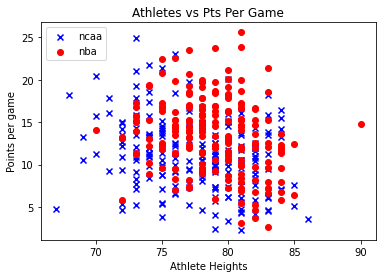

In [13]:
sample = nba_college_data.sample(n=200, random_state=1) # get our sample of 200 NBA players

fig, ax = plt.subplots()
ax.scatter(top_college_players.height, top_college_players.NCAA_ppg, c='b', marker="x", label='ncaa')
ax.scatter(sample.height, sample.NCAA_ppg, c='r', marker="o", label='nba')

ax.set_xlabel("Athlete Heights")
ax.set_ylabel("Points per game")
ax.set_title("Athletes heights vs Pts Per Game")
plt.legend(loc='upper left');
plt.show()

So we see a concetration of players who are 6' or above score rather well but we see it tapper off near the upper bound of 85" or 7' 1" for the NCAA. For the sample of NBA players we see more of a concentration towards 77.5.

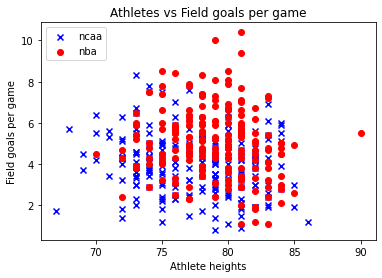

In [14]:
fig, ax = plt.subplots()
ax.scatter(top_college_players.height, top_college_players.NCAA_fgpg, c='b', marker="x", label='ncaa')
ax.scatter(sample.height, sample.NCAA_fgpg, c='r', marker="o", label='nba')

ax.set_xlabel("Athlete heights")
ax.set_ylabel("Field goals per game")
ax.set_title("Athletes heights vs Field goals per game")
plt.legend(loc='upper left');
plt.show()

Similar statistics hold for field goals which is expected since majority of points are field goals.

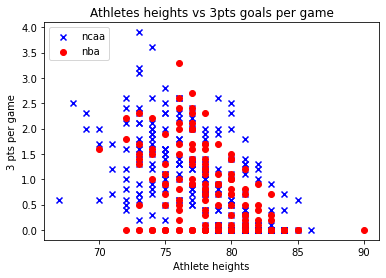

In [15]:
fig, ax = plt.subplots()
ax.scatter(top_college_players.height, top_college_players.NCAA__3ptpg, c='b', marker="x", label='ncaa')
ax.scatter(sample.height, sample.NCAA__3ptpg, c='r', marker="o", label='nba')

ax.set_xlabel("Athlete heights")
ax.set_ylabel("3 pts per game")
ax.set_title("Athletes heights vs 3pts goals per game")
plt.legend(loc='upper left');
plt.show()

And this pattern repeates stronger for 3pts per game for the NCAA. For the NBA we also see a concetration of athletes scoring 3s towards 77.5 but it's not that significant./ All this indicates height plays a role to an extent but people who are extremely tall don't play as much of a presence in scoring pts.

# Hypothesis Testing
Now I want to find NBA players that draw similarities to each NCAA athlete and use them as a projection to see how each NCAA athlete  may perform in the NBA.

We can do this by doing cosine similarity and minimizing the distance to a player.

# Finding similar players - cosine similarity
To perform find the most similar players, we iterate through each college player and compare them to each NBA players statistics using cosine similarity and find the closest one by minimizing this distance metric. We may find some better results if we weight certain statistics higher such as certain type of shots scored, but this should give us a rough estimate.

In [16]:
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
import time

df1 = top_college_players.drop(columns=['college'])
df2 = nba_college_data.drop(columns=['college'])

start = time.time()
for i, row1 in df1.iterrows():
    closest_nba_player = (float('inf'), None)
    v1 = row1.drop(labels='name')
    for j, row2 in df2.iterrows():
        nba_player = row2['name']
        v2 = row2.drop(labels='name')
        cosine_dist = 1 - np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
        if closest_nba_player[0] > cosine_dist:
            closest_nba_player = (cosine_dist, nba_player)
    if closest_nba_player[1] == None:
        print(row1['name'])
    top_college_players.at[i, 'dist_nba_player'] = closest_nba_player[0] 
    top_college_players.at[i, 'closest_nba_player'] = closest_nba_player[1] 

end = time.time()
print(end - start)

top_college_players

251.29526376724243


,name,college,height,weight,NCAA_games,NCAA_fgpg,NCAA_fgapg,NCAA_fgpct,NCAA__3ptpg,NCAA__3ptapg,NCAA__3ptpct,NCAA_ftpg,NCAA_ftapg,NCAA_ppg,dist_nba_player,closest_nba_player
0,Luka Garza,Iowa,83,265.0,127.0,6.9,12.6,0.546,0.9,2.6,0.367,3.5,5.0,18.2,0.000082,Melvin Ely
1,Max Abmas,Oral Roberts,73,165.0,59.0,6.5,14.5,0.448,3.2,8.0,0.399,3.1,3.5,19.3,0.000410,Troy Hudson
2,Cameron Thomas,LSU,76,210.0,29.0,7.0,17.2,0.406,2.3,7.2,0.325,6.7,7.6,23.0,0.000343,Eric Gordon
3,Drew Timme,Gonzaga,82,235.0,65.0,5.6,8.8,0.641,0.1,0.4,0.292,3.0,4.5,14.3,0.000025,John Collins
4,Corey Kispert,Gonzaga,79,220.0,137.0,4.1,8.4,0.483,2.0,4.8,0.408,1.5,1.8,11.6,0.000038,Naz Mitrou-Long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,CJ Fredrick,Iowa,75,195.0,52.0,3.1,6.4,0.479,1.6,3.4,0.466,1.1,1.5,8.8,0.000218,Adonis Thomas
204,Carl Pierre,UMass,76,190.0,111.0,4.1,10.4,0.399,2.6,6.7,0.384,1.3,1.7,12.2,0.000044,Eric Washington
205,Michael Ertel,Alabama-Birmingham,74,190.0,29.0,5.0,12.3,0.406,1.2,4.3,0.270,2.0,2.5,13.2,0.000141,Javaris Crittenton
206,Noah Frederking,Evansville,76,210.0,121.0,2.3,5.8,0.393,1.4,3.7,0.364,0.8,1.1,6.7,0.000095,Jamal Robinson


In [17]:
nba_similar_players = pd.DataFrame()
for i, row in top_college_players.iterrows():
    sim_player = nba_college_data[nba_college_data['name'] == row['closest_nba_player']]
    if not sim_player.empty:
        nba_similar_players = nba_similar_players.append(sim_player)
nba_similar_players

,name,college,height,weight,NCAA_games,NCAA_fgpg,NCAA_fgapg,NCAA_fgpct,NCAA__3ptpg,NCAA__3ptapg,NCAA__3ptpct,NCAA_ftpg,NCAA_ftapg,NCAA_ppg
1158,Melvin Ely,"California State University, Fresno",82,260.0,124.0,6.4,11.0,0.577,0.0,0.0,0.333,3.0,4.6,15.7
1862,Troy Hudson,"University of Missouri, Southern Illinois Univ...",73,170.0,57.0,6.9,17.6,0.391,4.0,10.8,0.371,2.8,3.5,20.6
1457,Eric Gordon,Indiana University,76,215.0,32.0,5.8,13.3,0.433,2.2,6.5,0.337,7.2,8.7,20.9
750,John Collins,Wake Forest University,82,235.0,64.0,4.9,8.2,0.601,0.0,0.0,0.000,3.6,4.9,13.4
2803,Naz Mitrou-Long,Iowa State University,76,209.0,131.0,3.3,7.3,0.451,2.0,5.2,0.380,1.0,1.3,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,Adonis Thomas,"University of North Carolina, University of Me...",79,200.0,55.0,4.1,9.5,0.426,0.7,2.3,0.325,1.9,2.5,10.7
4256,Eric Washington,University of Alabama,76,190.0,112.0,4.7,10.9,0.435,2.3,6.1,0.386,1.9,2.4,13.7
835,Javaris Crittenton,Georgia Institute of Technology,77,200.0,32.0,4.9,11.0,0.450,1.1,3.2,0.356,3.4,4.3,14.4
3454,Jamal Robinson,University of Virginia,79,212.0,122.0,2.5,6.0,0.410,0.4,1.3,0.270,1.1,1.7,6.3


Just by a rough analysis, we find some interesting similarities between each player. Just looking at the first player, it seems that Luka Garza has the same build as Melvin Ely both 82" and roughly 260 lbs. Both Ely and Garza also have roughly the same games played and field goals per game.

We also see how John Collins and Drew Timme play having exactly the same height and weight, and similar playing statistics. Still, it may seem on initial analysis that we currently are pairing players by their size and not as much by play quality.

# Visualization
These tables are great and all but it's pretty hard to the picture just from them. Howevever, visualizing them based on various metrics may help us get a better picture.

First let's see our spread of the cosine distance to see how well we found matches with our data.

0.0001746821520772282
6.609619522812693e-06
0.0021104464954052604


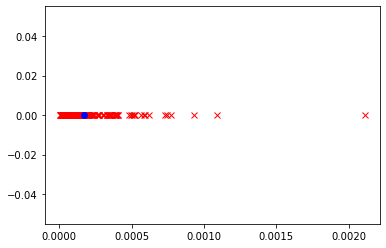

In [18]:
only_matched = top_college_players[top_college_players['dist_nba_player'] != float('inf')]
arr = only_matched['dist_nba_player']
plt.plot(arr, np.zeros_like(arr), 'rx')
print(arr.mean())
print(arr.min())
print(arr.max())

plt.plot(arr.mean(), np.zeros_like(arr.mean()), 'bo')

We see a relatively cocentrated distribution around the mean of 0.00017 but we still see a couple values that are further spread. It still seems we have found decent matches as none are really far from 0.

## Comparing metrics
To get a real understanding of how each player compares to their `closest_nba_player` we should see how their stats look side by side. I'll be comparing the points per game, field goals per game, and 3 pointers per game between the pair (NCAA athelete and the similar NBA player). Also since we aren't doing any normalization and since the weight is way higher relative to other metrics, it maybe overplaying its role.

In [19]:
def get_get_y (metric, df1=top_college_players, df2=nba_college_data, norm=False):
    y = [[], []]
    if norm:
        y.append([])
    for i, ncaa_player in df1.iterrows():
        nba_player = df2.loc[nba_college_data['name'] == ncaa_player['closest_nba_player']]
        if not nba_player.empty :
            y[0].append(ncaa_player[metric])
            y[1].append(float(nba_player[metric].iloc[0]))
        if norm:
            norm_nba_player = df2.loc[nba_college_data['name'] == ncaa_player['norm_closest_nba_player']]
            y[2].append(float(norm_nba_player[metric].iloc[0]))
    return y

def generate_plt (x, y1, y2, x_label="Players", y_label="points per game", title="nba vs ncaa stats"):
    fig, ax = plt.subplots()
    ax.scatter(only_matched.name[:50], pts_per_game[0][:50], c='b', marker="x", label='ncaa')
    ax.scatter(only_matched.name[:50], pts_per_game[1][:50], c='r', marker="o", label='nba')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Points per game")
    ax.set_title(title)
    plt.legend(loc='upper left');
    plt.show()

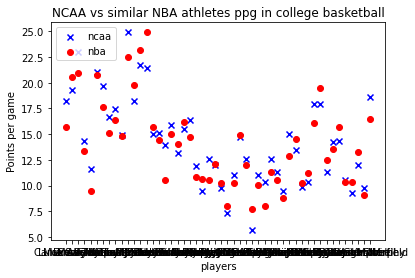

In [20]:
pts_per_game = get_get_y('NCAA_ppg')

generate_plt(only_matched.name[:50], pts_per_game[0][:50], pts_per_game[1][:50], "players", "points per game", "NCAA vs similar NBA athletes ppg in college basketball")
plt.show()

Each pair seems to have found a a very similar player for NCAA points per game, as lots of players seem either .5-1 points off from their NBA counterpart

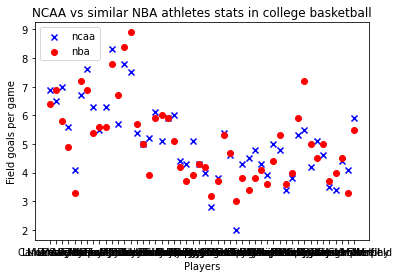

In [21]:
fg_per_game = get_get_y('NCAA_fgpg')
        
fig, ax = plt.subplots()
ax.scatter(only_matched.name[:50], fg_per_game[0][:50], c='b', marker="x", label='ncaa')
ax.scatter(only_matched.name[:50], fg_per_game[1][:50], c='r', marker="o", label='nba')
ax.set_xlabel("Players")
ax.set_ylabel("Field goals per game")
ax.set_title("NCAA vs similar NBA athletes fgpg in college basketball")
plt.legend(loc='upper left');
plt.show()

For field goals per game we find that most NBA players scoring above their match which may or may not be indicative of anything.

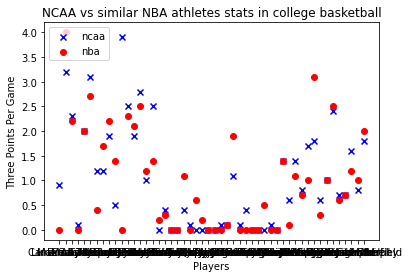

In [22]:
three_ptpg = get_get_y('NCAA__3ptpg')
        
fig, ax = plt.subplots()
ax.scatter(only_matched.name[:50], pd.to_numeric(three_ptpg[0][:50]), c='b', marker="x", label='ncaa')
ax.scatter(only_matched.name[:50], three_ptpg[1][:50], c='r', marker="o", label='nba')
ax.set_xlabel("Players")
ax.set_ylabel("Three Points Per Game")
ax.set_title("NCAA vs similar NBA athletes 3ptpg in college basketball")
plt.legend(loc='upper left');
plt.show()

3 Points shots per game are pretty low (or even mostly 0) anyways so it seems that it won't be weighted as highly when making a match. Still it seems we have found pretty closely related pairs of players.

# Normalizing statistics
Seeing how a player's weight seems overweighted compared to stats like points per game and threes per game, we should see what happens if we normalize each metric. We likely will find more players with closer statistics but maybe different sizes.

In [23]:
df = top_college_players.select_dtypes(include=[np.number])
df = df.drop(columns=['dist_nba_player'])
top_college_players_norm = (df-df.mean())/df.std()
top_college_players_norm['name'] = top_college_players['name']
df = nba_college_data.select_dtypes(include=[np.number])
nba_college_data_norm = (nba_college_data-nba_college_data.mean())/nba_college_data.std()
nba_college_data_norm['name'] = nba_college_data['name']
nba_college_data_norm = nba_college_data_norm.drop(columns=['college'])
top_college_players_norm

,height,weight,NCAA_games,NCAA_fgpg,NCAA_fgapg,NCAA_fgpct,NCAA__3ptpg,NCAA__3ptapg,NCAA__3ptpct,NCAA_ftpg,NCAA_ftapg,NCAA_ppg,name
0,1.423463,2.037644,1.779492,2.009062,1.244489,0.811478,-0.126847,-0.103470,0.463975,1.024861,1.213643,1.646520,Luka Garza
1,-1.146678,-1.491625,-0.207807,1.731950,1.825358,-0.371555,2.488818,2.239629,0.661216,0.703578,0.268183,1.906473,Max Abmas
2,-0.375636,0.096546,-1.084556,2.078340,2.650803,-0.878570,1.465297,1.892503,0.205095,3.595124,2.852440,2.780861,Cameron Thomas
3,1.166449,0.978863,-0.032457,1.108448,0.082750,1.958297,-1.036643,-1.058066,0.001689,0.623258,0.898490,0.724869,Drew Timme
4,0.395406,0.449473,2.071742,0.069278,-0.039538,0.050957,1.124123,0.851126,0.716691,-0.581553,-0.803338,0.086802,Corey Kispert
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,-0.632650,-0.432844,-0.412381,-0.623502,-0.650979,0.002670,0.669225,0.243656,1.074192,-0.902836,-0.992430,-0.574896,CJ Fredrick
204,-0.375636,-0.609308,1.311893,0.069278,0.571903,-0.963072,1.806471,1.675550,0.568759,-0.742194,-0.866368,0.228595,Carl Pierre
205,-0.889664,-0.609308,-1.084556,0.692780,1.152772,-0.878570,0.214327,0.634172,-0.133915,-0.179949,-0.362123,0.464916,Michael Ertel
206,-0.375636,0.096546,1.604143,-1.177726,-0.834411,-1.035503,0.441776,0.373828,0.445483,-1.143798,-1.244552,-1.071170,Noah Frederking


In [24]:
start = time.time()
for i, row1 in top_college_players_norm.iterrows():
    closest_nba_player = (float('inf'), None)
    v1 = row1.drop(labels='name')
    for j, row2 in nba_college_data_norm.iterrows():
        nba_player = row2['name']
        v2 = row2.drop(labels='name')
        cosine_dist = 1 - np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
        if closest_nba_player[0] > cosine_dist:
            closest_nba_player = (cosine_dist, nba_player)
    if closest_nba_player[1] == None:
        print(row1['name'])
    top_college_players.at[i, 'norm_dist_nba_player'] = closest_nba_player[0] 
    top_college_players.at[i, 'norm_closest_nba_player'] = closest_nba_player[1] 

end = time.time()
print(end - start)

top_college_players

332.6718518733978


,name,college,height,weight,NCAA_games,NCAA_fgpg,NCAA_fgapg,NCAA_fgpct,NCAA__3ptpg,NCAA__3ptapg,NCAA__3ptpct,NCAA_ftpg,NCAA_ftapg,NCAA_ppg,dist_nba_player,closest_nba_player,norm_dist_nba_player,norm_closest_nba_player
0,Luka Garza,Iowa,83,265.0,127.0,6.9,12.6,0.546,0.9,2.6,0.367,3.5,5.0,18.2,0.000082,Melvin Ely,0.101762,Wally Szczerbiak
1,Max Abmas,Oral Roberts,73,165.0,59.0,6.5,14.5,0.448,3.2,8.0,0.399,3.1,3.5,19.3,0.000410,Troy Hudson,0.107367,Danny Fortson
2,Cameron Thomas,LSU,76,210.0,29.0,7.0,17.2,0.406,2.3,7.2,0.325,6.7,7.6,23.0,0.000343,Eric Gordon,0.205967,Jason Thompson
3,Drew Timme,Gonzaga,82,235.0,65.0,5.6,8.8,0.641,0.1,0.4,0.292,3.0,4.5,14.3,0.000025,John Collins,0.202506,Mike Batiste
4,Corey Kispert,Gonzaga,79,220.0,137.0,4.1,8.4,0.483,2.0,4.8,0.408,1.5,1.8,11.6,0.000038,Naz Mitrou-Long,0.229927,Isaiah Canaan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,CJ Fredrick,Iowa,75,195.0,52.0,3.1,6.4,0.479,1.6,3.4,0.466,1.1,1.5,8.8,0.000218,Adonis Thomas,0.218897,Dave Henderson
204,Carl Pierre,UMass,76,190.0,111.0,4.1,10.4,0.399,2.6,6.7,0.384,1.3,1.7,12.2,0.000044,Eric Washington,0.377861,Keith Booth
205,Michael Ertel,Alabama-Birmingham,74,190.0,29.0,5.0,12.3,0.406,1.2,4.3,0.270,2.0,2.5,13.2,0.000141,Javaris Crittenton,0.320450,Kelly Tripucka
206,Noah Frederking,Evansville,76,210.0,121.0,2.3,5.8,0.393,1.4,3.7,0.364,0.8,1.1,6.7,0.000095,Jamal Robinson,0.190333,Taurean Green


Like we did earlier, let's see how far our normalized matches by the cosine distance. 

0.23212698910470606
0.05150922119018109
0.6258868285091335


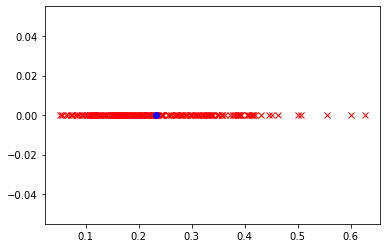

In [25]:
arr = top_college_players['norm_dist_nba_player']
plt.plot(arr, np.zeros_like(arr), 'rx')
print(arr.mean())
print(arr.min())
print(arr.max())

plt.plot(arr.mean(), np.zeros_like(arr.mean()), 'bo')

Well that didn't quite turn out as expected, seems we upped the spread quite a bit as we aren not as close to 0 as were before normalizing and it seems that may not have gotten as good matches as before.

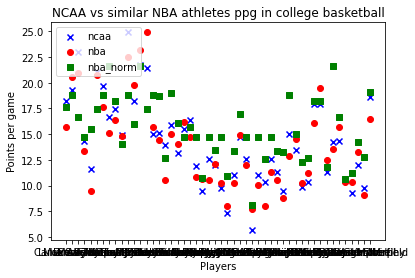

In [35]:
pts_per_game = get_get_y('NCAA_ppg', norm=True)
        
fig, ax = plt.subplots()
ax.scatter(only_matched.name[:50], pts_per_game[0][:50], c='b', marker="x", label='ncaa')
ax.scatter(only_matched.name[:50], pts_per_game[1][:50], c='r', marker="o", label='nba')
ax.scatter(only_matched.name[:50], pts_per_game[2][:50], c='g', marker="s", label='nba_norm')

ax.set_xlabel("Players")
ax.set_ylabel("Points per game")
ax.set_title("NCAA vs similar NBA athletes ppg in college basketball")
plt.legend(loc='upper left');
plt.show()

The points points per game sometimes can offer an as good of an athelete but in general we haven't really gotten much closer to finding a player that will 'match' the NCAA player in statistics.

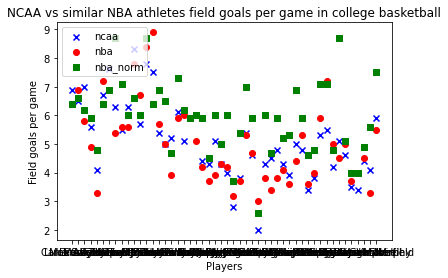

In [31]:
fg_per_game = get_get_y('NCAA_fgpg', norm=True)
        
fig, ax = plt.subplots()
ax.scatter(only_matched.name[:50], fg_per_game[0][:50], c='b', marker="x", label='ncaa')
ax.scatter(only_matched.name[:50], fg_per_game[1][:50], c='r', marker="o", label='nba')
ax.scatter(only_matched.name[:50], fg_per_game[2][:50], c='g', marker="s", label='nba_norm')

ax.set_xlabel("Players")
ax.set_ylabel("Field goals per game")
ax.set_title("NCAA vs similar NBA athletes field goals per game in college basketball")
plt.legend(loc='upper left');
plt.show()

For field goals per game it seems the players selected by the normalized values are consistently above their matched NCAA player and don't seem to be as good of a match for this category as the NBA player matched without normalization.

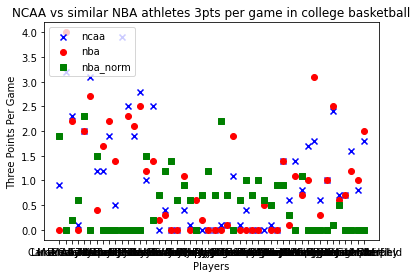

In [34]:
three_ptpg = get_get_y('NCAA__3ptpg', norm=True)
        
fig, ax = plt.subplots()
ax.scatter(only_matched.name[:50], pd.to_numeric(three_ptpg[0])[:50], c='b', marker="x", label='ncaa')
ax.scatter(only_matched.name[:50], three_ptpg[1][:50], c='r', marker="o", label='nba')
ax.scatter(only_matched.name[:50], three_ptpg[2][:50], c='g', marker="s", label='nba_norm')

ax.set_xlabel("Players")
ax.set_ylabel("Three Points Per Game")
ax.set_title("NCAA vs similar NBA athletes 3pts per game in college basketball")
plt.legend(loc='upper left');
plt.show()

This graph is the most surprising of the bunch, as I'd assume normalizing all the statisics would allow us to get nba athletes that score threes more closely related to their NCAA counterpart. Thought it also makes sense that it would have no weighting in the cosine distance as for many athletes they're three per game was 0 and just made it more important to weight other categories. 

It also seems to mean that normalizing ultimately didn't help improve us find a better match for an athelete.

# Conclusion

As discussed earlier, we found that normalizing values when computing cosine distance may have been ineffective and using the base values gave better matches. If we were to extend this project, I'd suggest using K-Nearest Neighbors to find matches as we'd get a cluster of potential matches, which may yield better results than cosine distance.

I'd also suggest trying to build projections based on these matches to get a better guage on how they may perform in the NBA based on prior athletes that had similar statistics. 

## Discussion on matches and Luka Garza
Regardless, we did find some very good matches as if we compare Luka Garza to his match without normalization, Melvin Ely. Draft prospects believe Garza's too slow to perform well in the NBA and believe he'd fall to 2nd or even lower rounds of the NBA draft as stated [here](https://www.si.com/college/2021/03/22/luka-garza-nba-future-iowa-march-madness-daily-cover). Sadly we don't have any statistics to match based on actual speed so we can't really make any conclusion on that front, but he's been as effective as Ely as seen here:

In [36]:
garza = top_college_players[top_college_players['name'] == 'Luka Garza']
garza

,name,college,height,weight,NCAA_games,NCAA_fgpg,NCAA_fgapg,NCAA_fgpct,NCAA__3ptpg,NCAA__3ptapg,NCAA__3ptpct,NCAA_ftpg,NCAA_ftapg,NCAA_ppg,dist_nba_player,closest_nba_player,norm_dist_nba_player,norm_closest_nba_player
0,Luka Garza,Iowa,83,265.0,127.0,6.9,12.6,0.546,0.9,2.6,0.367,3.5,5.0,18.2,0.000082,Melvin Ely,0.101762,Wally Szczerbiak


In [37]:
ely = nba_college_data[nba_college_data['name'] == 'Melvin Ely']
ely

,name,college,height,weight,NCAA_games,NCAA_fgpg,NCAA_fgapg,NCAA_fgpct,NCAA__3ptpg,NCAA__3ptapg,NCAA__3ptpct,NCAA_ftpg,NCAA_ftapg,NCAA_ppg
1158,Melvin Ely,"California State University, Fresno",82,260.0,124.0,6.4,11.0,0.577,0.0,0.0,0.333,3.0,4.6,15.7


The main difference comes form the 3ptpg , but this maybe just because Ely's data maybe missing which could be possible has we have a value for the 3pt percentage but not the 3pt per game itself.

Ely was a first round pick, which may indicate that Garza should be drafted as high as him, as both have very similar statistics and physical traits. Interestingly, articles do bash Ely for being [slow](https://bleacherreport.com/articles/907872-25-most-useless-nba-players-of-the-past-decade) and the reason Garza may have been deemed a poor draft prospect is because his build and style is similar to players like Ely, who have been deemed as not as good as they were expected. 

In [40]:
filter_nba = [col for col in nba_data if col.startswith('NBA')]

ely_nba = nba_data[nba_data['name'] == 'Melvin Ely'][filter_nba]
ely_nba

,NBA__3ptapg,NBA__3ptpct,NBA__3ptpg,NBA_efgpct,NBA_fg%,NBA_fg_per_game,NBA_fga_per_game,NBA_ft%,NBA_ft_per_g,NBA_fta_p_g,NBA_g_played,NBA_ppg
1158,0.0,0.0,0.0,0.46,0.46,2.1,4.5,0.625,1.1,1.8,375,5.3


We definitely see a drop in his performance as his points per game dropped from 15.7 in the NCAA to 5.3 so we could definitely see a similar decline for Garza based on this performance and it is does make sense why analysts may not be sold on Garza.

## Final thoughts
Throughout this project, I've got a better hold on how to determine similarity and I have a good gauge on the general data science pipeline.  There's a few things, I wish I wish to have implemented such as K-Nearest Neighbors but due time constraints and general busyiness, things were cut. I hope you enjoyed my project!